In [1]:
from data import Data
from options import Options
import os
import sys
from xgbooster import XGBooster, preprocess_dataset, discretize_dataset
import random
from pysat.card import EncType
import numpy as np
import functools
from other.stats import cal_ffa, cal_wffa, attr_plot
import matplotlib.pyplot as plt
%matplotlib inline  

# Train a gradient boosted tree

In [2]:
# Paths of prepared training and test data
train = '../datasets/tabular/train/compas/compas_train_data.csv'
test = '../datasets/tabular/test/compas/compas_test_data.csv'

In [3]:
# Parse configuration of the training process
options = Options()
# Output location
options.output = './btmodels/compas/'
options.use_categorical = True
options.testsplit = 0.0
options.train = True
# The number of trees in each class
options.n_estimators = 25
# The max depth in each tree
options.maxdepth = 3
# Set training file location
options.files = [train]

In [4]:
#Start training
if not os.path.isdir(options.output):
    os.makedirs(options.output)
data = Data(filename=options.files[0], mapfile=options.mapfile,
            separator=options.separator,
            use_categorical = options.use_categorical)

xgb = XGBooster(options, from_data=data)
_, _, model = xgb.train()

Attempt: loading extra data from  ../datasets/tabular/train/compas/compas_train_data.csv.pkl
loaded
start xgb
end xgb
saving  model to  ./btmodels/compas//compas_train_data/compas_train_data_nbestim_25_maxdepth_3_testsplit_0.0.mod.pkl
saving  data to  ./btmodels/compas//compas_train_data/compas_train_data_nbestim_25_maxdepth_3_testsplit_0.0.mod.pkl.splitdata.pkl
saving plain model to  ./btmodels/compas//compas_train_data/compas_train_data_nbestim_25_maxdepth_3_testsplit_0.0.mod.txt
no results test data
saving results to  ./btmodels/compas//compas_train_data/compas_train_data_nbestim_25_maxdepth_3_testsplit_0.0.res.txt


# Enumerate abductive explanations then generate (weighted) feature attribution 

In [5]:
# Configuration for explaining
options = Options()
options.encode = 'mx'
options.am1 = True
options.exhaust = True
options.trim = 1
options.minz = True
options.use_categorical = True
options.xtype = 'con'
options.reduce = 'lin'
options.sort = 'abs'
options.xnum = -1
options.smallest = True
options.explain_ = 'formal'
options.solver = 'm22'
options.cardenc = EncType.seqcounter
xgb.options = options
xgb.encode()

# Prepare the explainer
explainer = xgb.explainer()

In [6]:
# Testing dataset
with open(test, 'r') as fp:
    test_samples = fp.readlines()[1:]
X_test = list(map(lambda l: l[: l.rfind(',')], test_samples))

## Explaining the instance

In [7]:
# The index of the instance to explain
inst_id = 5
# Parse the selected instance to the particular format
test_instance = np.array([float(v.strip()) for v in X_test[inst_id].split(',')])

In [8]:
# Explaining
explainer.explain(test_instance, options.smallest, inst_id)
def get_axp(expl):
    hyps = list(functools.reduce(lambda x, y: x + explainer.hypos[y[0]:y[1] + 1], [explainer.fcats[c] for c in expl], []))
    axp = sorted(set(map(lambda v: explainer.v2feat[v], hyps)))
    return axp
# The generated abductive explanations
axps =  list(map(lambda l: get_axp(l), explainer.duals))

## Compute formal feature attribution

Explaining: Number_of_Priors == 5.0 AND score_factor == 1 AND Age_Above_FourtyFive == 0 AND Age_Below_TwentyFive == 0 AND African_American == 1 AND Asian == 0 AND Hispanic == 0 AND Native_American == 0 AND Other == 0 AND Female == 0 AND Misdemeanor == 0
Prediction: 1
Feature Attribution:


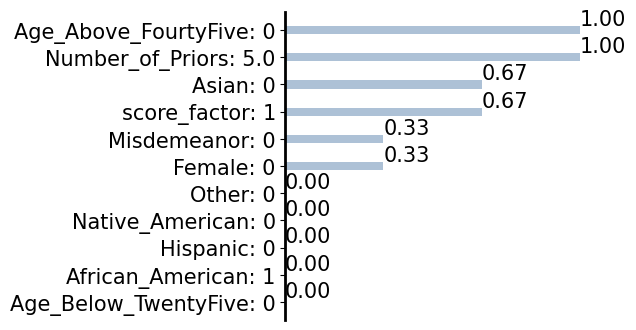

In [9]:
# Calculate formal feature attribution
ffa = cal_ffa(axps)
for fid in range(len(explainer.preamble)):
    if fid not in ffa:
        ffa[fid] = 0.00

# Generate formal feature attribution plot
names = []
values = []
for fid in sorted(ffa.keys(), key=lambda l: (ffa[l], l)):
    names.append(explainer.preamble[fid].replace(' == ', ': '))
    values.append(ffa[fid])

pred = explainer.xgb.target_name[explainer.out_id]
print('Explaining:', ' AND '.join(explainer.preamble))
print('Prediction:', pred)
print('Feature Attribution:')
attr_plot(explainer.preamble, ffa, names=names, values=values)

## Compute weighted feature attribution

Explaining: Number_of_Priors == 5.0 AND score_factor == 1 AND Age_Above_FourtyFive == 0 AND Age_Below_TwentyFive == 0 AND African_American == 1 AND Asian == 0 AND Hispanic == 0 AND Native_American == 0 AND Other == 0 AND Female == 0 AND Misdemeanor == 0
Prediction: 1
Weighted Feature Attribution:


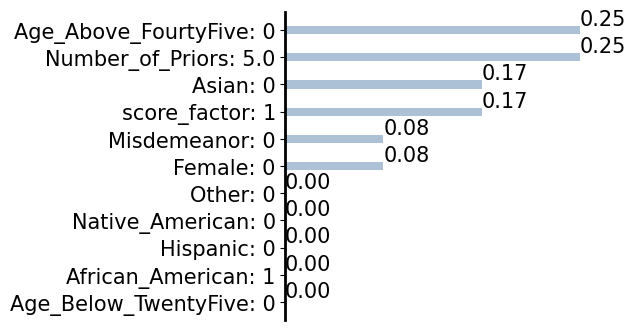

In [10]:
# Calculate weighted formal feature attribution
wffa = cal_wffa(axps)
for fid in range(len(explainer.preamble)):
    if fid not in wffa:
        wffa[fid] = 0.00

# Generate weighted formal feature attribution plot
names = []
values = []
for fid in sorted(wffa.keys(), key=lambda l: (wffa[l], l)):
    names.append(explainer.preamble[fid].replace(' == ', ': '))
    values.append(wffa[fid])

pred = explainer.xgb.target_name[explainer.out_id]
print('Explaining:', ' AND '.join(explainer.preamble))
print('Prediction:', pred)
print('Weighted Feature Attribution:')
attr_plot(explainer.preamble, wffa, names=names, values=values)